<a href="https://colab.research.google.com/github/filippozuddas/ML-SRT-SETI/blob/main/notebooks/visualize_plates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizzazione Plate SRT

Questo notebook visualizza i backgrounds estratti da osservazioni SRT reali.
Questi plate vengono usati per iniettare segnali durante il training.

In [3]:
%matplotlib inline

In [1]:
import os, sys

working_dir = "/content/filippo/ML-SRT-SETI/"
os.chdir(working_dir)

if working_dir not in sys.path:
    sys.path.insert(0, working_dir)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os

from src.data.cadence_generator import CadenceGenerator, CadenceParams
from src.utils.preprocessing import normalize_log, preprocess, downscale

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 8

In [4]:
!pip install --force-reinstall pyparsing==2.4.7

  Using cached pyparsing-2.4.7-py2.py3-none-any.whl.metadata (3.6 kB)
Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.7
    Uninstalling pyparsing-2.4.7:
      Successfully uninstalled pyparsing-2.4.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydot 3.0.4 requires pyparsing>=3.0.9, but you have pyparsing 2.4.7 which is incompatible.


## 1. Caricamento Plate SRT

In [4]:
PLATE_PATH = 'data/srt_training/backgrounds_18GHz.npz'

if os.path.exists(PLATE_PATH):
    plate_data = np.load(PLATE_PATH)
    plates = plate_data['backgrounds']
    print(f'Shape: {plates.shape}')
    print(f'N backgrounds: {len(plates)}')
    print(f'Memory: {plates.nbytes / 1e9:.2f} GB')
else:
    print(f'Plate not found: {PLATE_PATH}')
    plates = None

Shape: (15000, 6, 16, 4096)
N backgrounds: 15000
Memory: 23.59 GB


## 2. Backgrounds Casuali

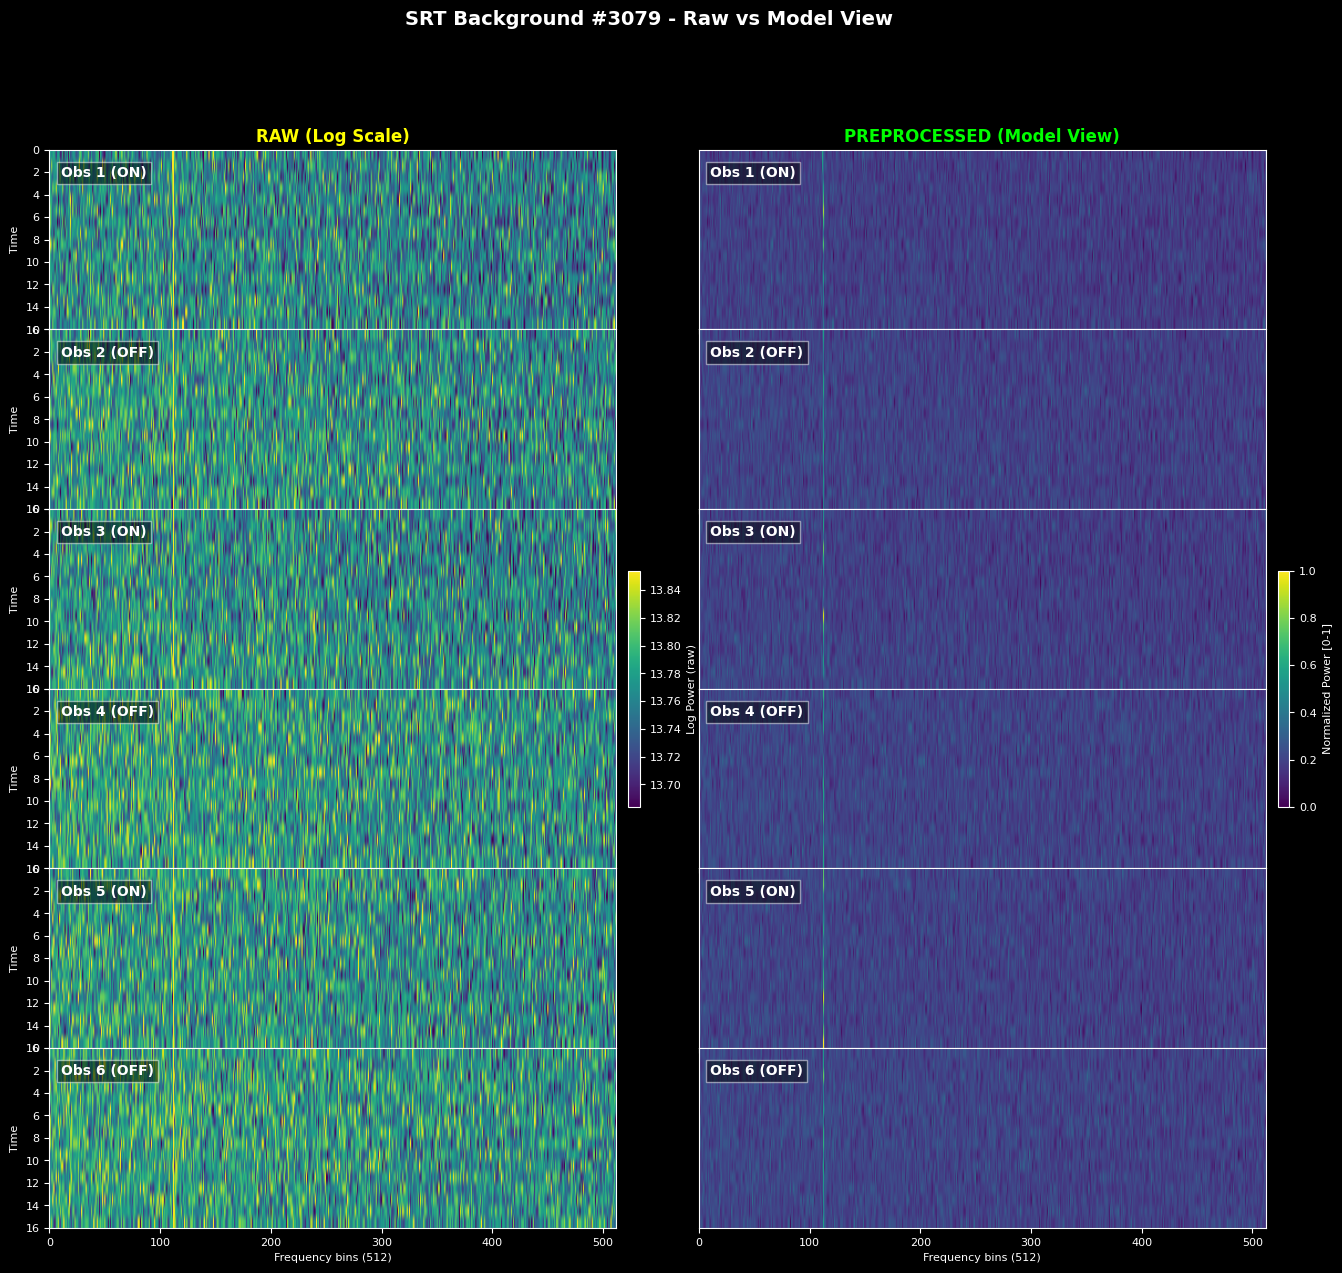

In [80]:
if plates is not None:
    labels = ['Obs 1 (ON)', 'Obs 2 (OFF)', 'Obs 3 (ON)', 'Obs 4 (OFF)', 'Obs 5 (ON)', 'Obs 6 (OFF)']

    # Random background
    idx = np.random.randint(len(plates))
    bg = plates[idx]  # (6, 16, 4096)

    # Downscale for both
    bg_ds = downscale(bg, factor=8)  # (6, 16, 512)

    # Raw: just log scale for visibility
    raw = np.log(np.abs(bg_ds) + 1e-10)
    raw_vmin, raw_vmax = np.percentile(raw, [1, 99])

    # Preprocessed: exactly like model sees
    processed = preprocess(bg_ds, add_channel=False)  # (6, 16, 512)

    # Create side-by-side comparison
    fig, axes = plt.subplots(6, 2, figsize=(16, 14), sharex=True)
    fig.subplots_adjust(hspace=0, wspace=0.1)

    for j in range(6):
        # RAW (left column)
        ax_raw = axes[j, 0]
        img_raw = ax_raw.imshow(raw[j], aspect='auto', cmap='viridis', origin='upper',
                                extent=[0, 512, raw[j].shape[0], 0],
                                vmin=raw_vmin, vmax=raw_vmax)
        ax_raw.text(0.02, 0.85, f'{labels[j]}', transform=ax_raw.transAxes,
                    fontsize=10, fontweight='bold', color='white',
                    bbox=dict(boxstyle='square', facecolor='black', alpha=0.5))
        ax_raw.set_ylabel('Time')
        if j < 5:
            ax_raw.tick_params(labelbottom=False)
        if j == 0:
            ax_raw.set_title('RAW (Log Scale)', fontsize=12, fontweight='bold', color='yellow')

        # PREPROCESSED (right column)
        ax_proc = axes[j, 1]
        img_proc = ax_proc.imshow(processed[j], aspect='auto', cmap='viridis', origin='upper',
                                  extent=[0, 512, processed[j].shape[0], 0],
                                  vmin=0, vmax=1)
        ax_proc.text(0.02, 0.85, f'{labels[j]}', transform=ax_proc.transAxes,
                     fontsize=10, fontweight='bold', color='white',
                     bbox=dict(boxstyle='square', facecolor='black', alpha=0.5))
        if j < 5:
            ax_proc.tick_params(labelbottom=False)
        ax_proc.set_yticks([])
        if j == 0:
            ax_proc.set_title('PREPROCESSED (Model View)', fontsize=12, fontweight='bold', color='lime')

    axes[5, 0].set_xlabel('Frequency bins (512)')
    axes[5, 1].set_xlabel('Frequency bins (512)')

    # Colorbars
    cbar_raw = fig.colorbar(img_raw, ax=axes[:, 0], orientation='vertical', fraction=0.02, pad=0.02)
    cbar_raw.set_label('Log Power (raw)')

    cbar_proc = fig.colorbar(img_proc, ax=axes[:, 1], orientation='vertical', fraction=0.02, pad=0.02)
    cbar_proc.set_label('Normalized Power [0-1]')

    fig.suptitle(f'SRT Background #{idx} - Raw vs Model View', fontsize=14, fontweight='bold')
    plt.show()

## 3. Griglia di Backgrounds

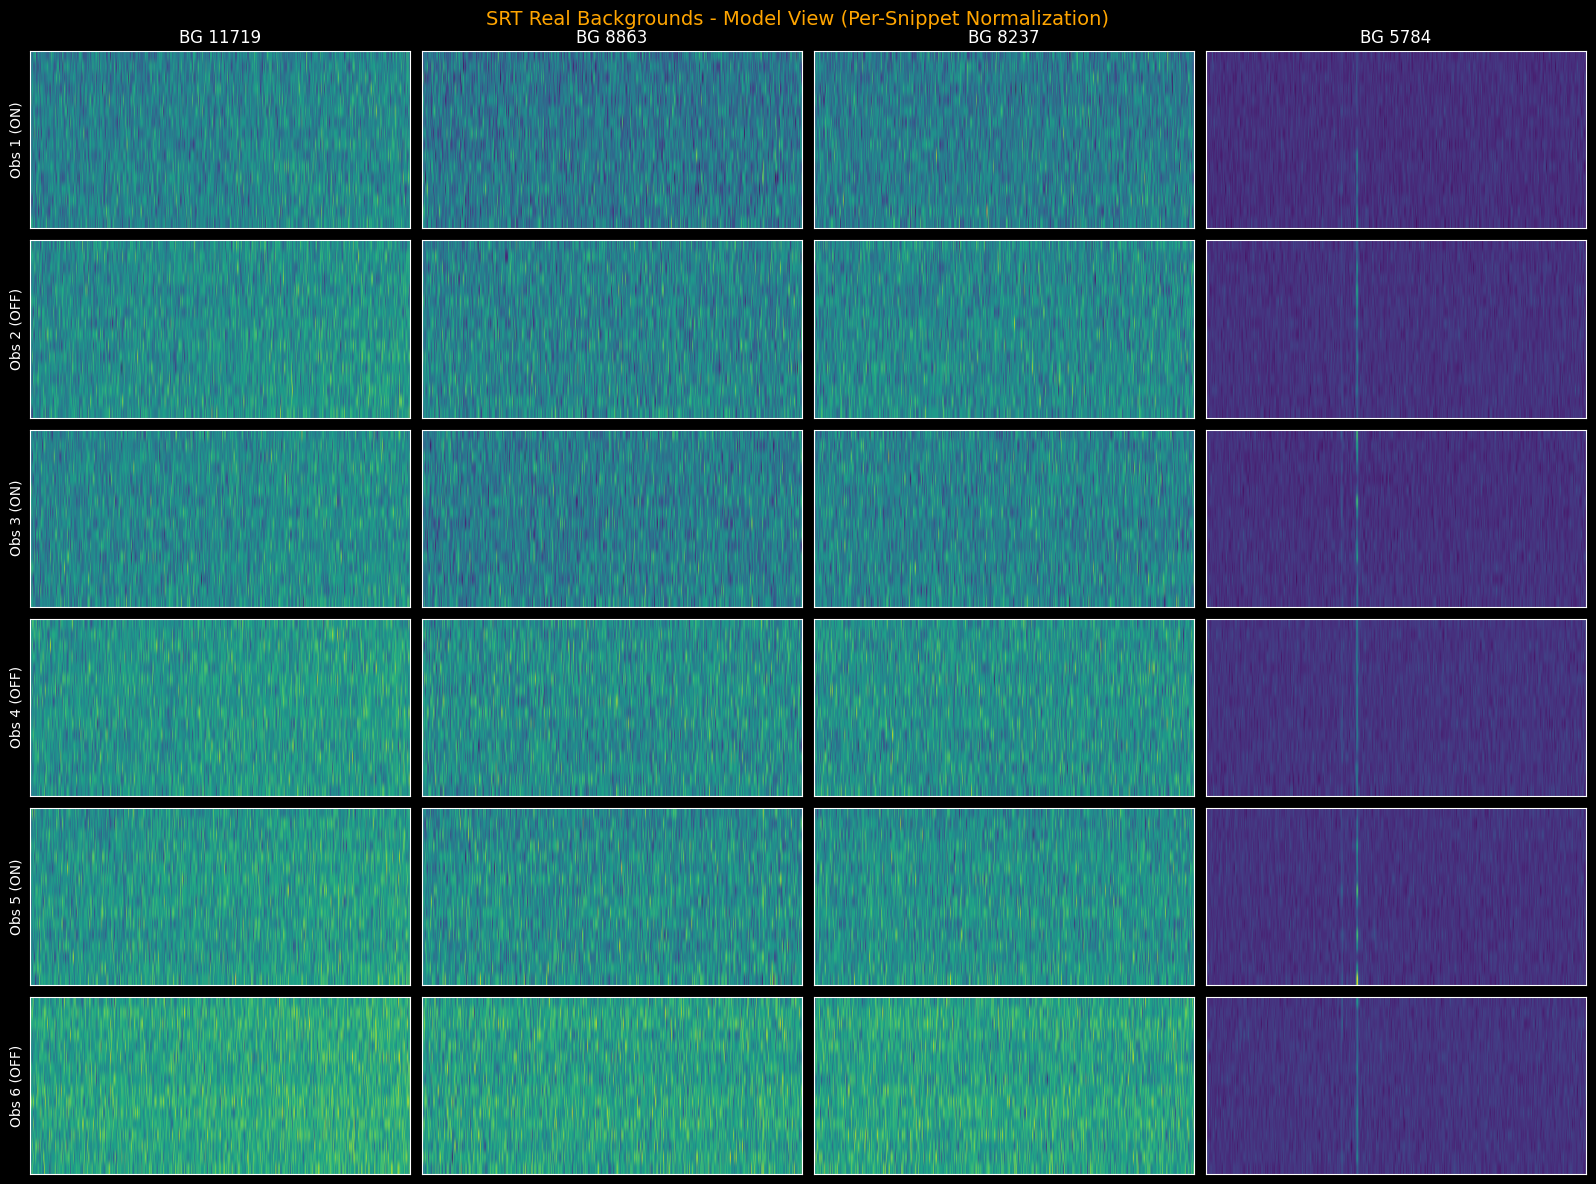

In [87]:
if plates is not None:
    n_samples = 4
    indices = np.random.choice(len(plates), n_samples, replace=False)
    labels = ['Obs 1 (ON)', 'Obs 2 (OFF)', 'Obs 3 (ON)', 'Obs 4 (OFF)', 'Obs 5 (ON)', 'Obs 6 (OFF)']

    fig, axes = plt.subplots(6, n_samples, figsize=(4*n_samples, 12))

    for col, idx in enumerate(indices):
        bg = plates[idx]  # (6, 16, 4096)
        # Downscale and preprocess ENTIRE snippet like the model sees
        bg_ds = downscale(bg, factor=8)  # (6, 16, 512)
        bg_proc = preprocess(bg_ds, add_channel=False)  # (6, 16, 512) normalized per-snippet

        for row in range(6):
            axes[row, col].imshow(bg_proc[row], aspect='auto', cmap='viridis', vmin=0, vmax=1)
            if col == 0:
                axes[row, col].set_ylabel(labels[row], fontsize=10)
            if row == 0:
                axes[row, col].set_title(f'BG {idx}', fontsize=12)
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])

    plt.suptitle('SRT Real Backgrounds - Model View (Per-Snippet Normalization)', fontsize=14, color='orange')
    plt.tight_layout()
    plt.show()

## 4. TRUE vs FALSE con Background SRT

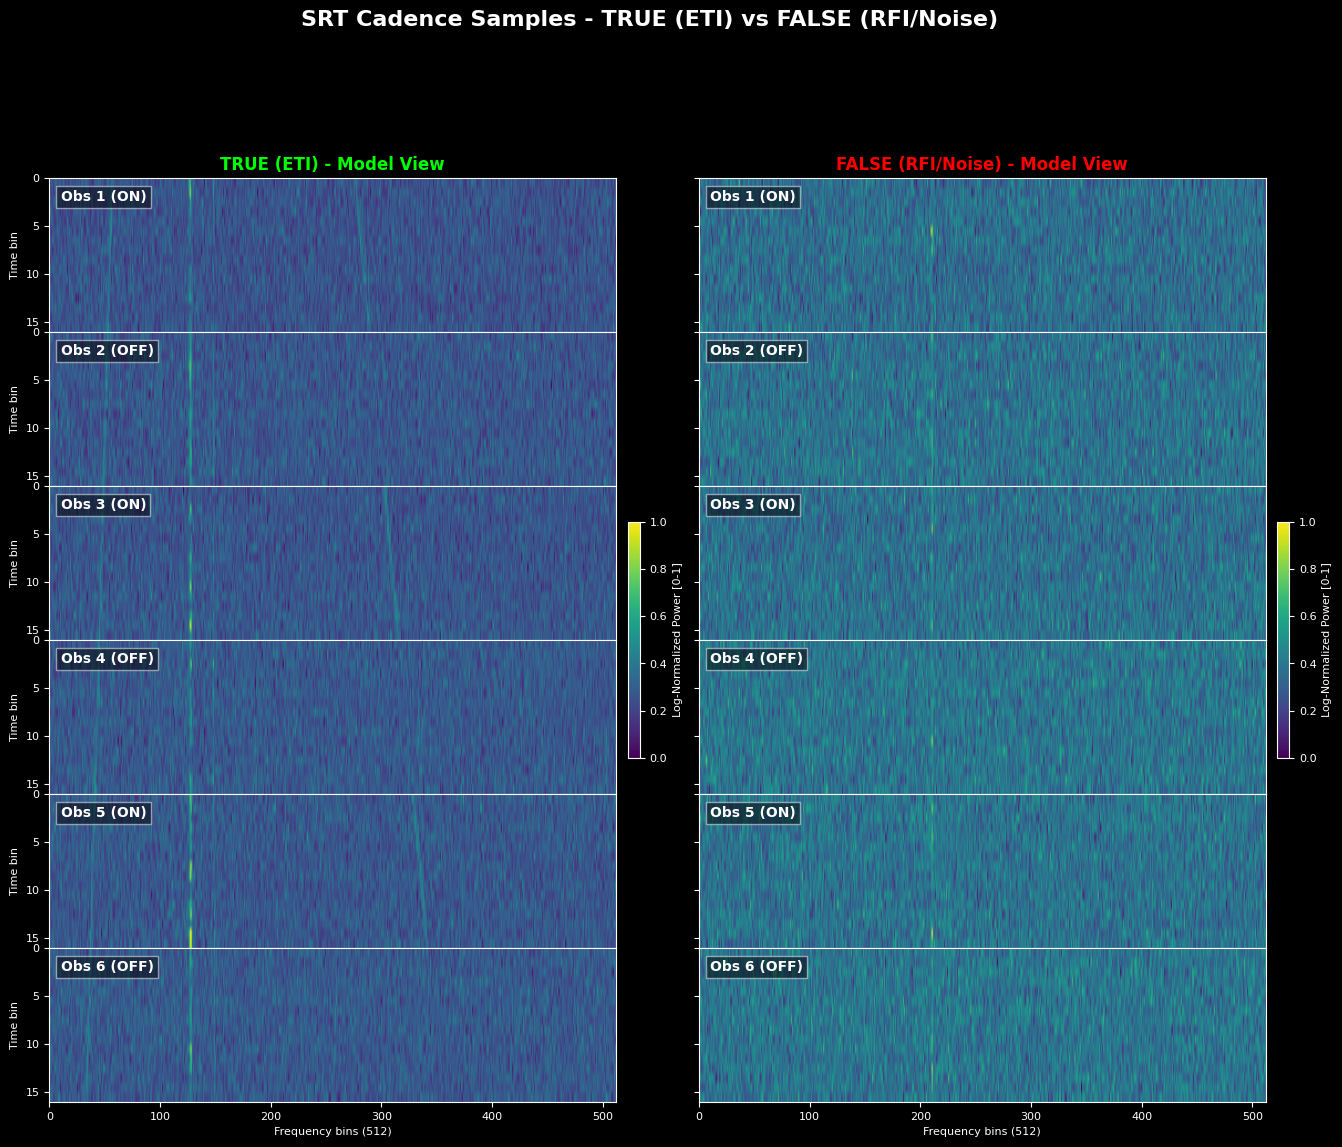

In [107]:
if plates is not None and CadenceGenerator is not None:
    srt_gen = CadenceGenerator(
        CadenceParams(fchans=4096, tchans=16, snr_base=10, snr_range=5),
        plate=plates, seed=None
    )

    true_srt = srt_gen.create_true_sample()[0]
    false_srt = srt_gen.create_false_sample()

    labels = ['Obs 1 (ON)', 'Obs 2 (OFF)', 'Obs 3 (ON)', 'Obs 4 (OFF)', 'Obs 5 (ON)', 'Obs 6 (OFF)']

    # Create a single figure with 6 rows and 2 columns
    fig, axes = plt.subplots(6, 2, figsize=(16, 12), sharex=True, sharey=True)

    # Adjust spacing between subplots
    fig.subplots_adjust(hspace=0, wspace=0.1)

    # --- Plot TRUE (ETI) sample in the first column ---
    sample_true_ds = downscale(true_srt, factor=8)
    processed_true = preprocess(sample_true_ds, add_channel=False)

    for j in range(6):
        ax = axes[j, 0] # Select current row, first column

        img_true = ax.imshow(processed_true[j], aspect='auto', cmap='viridis', origin='upper',
                             extent=[0, 512, processed_true[j].shape[0], 0],
                             vmin=0, vmax=1)

        ax.text(0.02, 0.85, f'{labels[j]}', transform=ax.transAxes,
                fontsize=10, fontweight='bold', color='white',
                bbox=dict(boxstyle='square', facecolor='black', alpha=0.5))

        if j == 0: # Set title only for the top-left subplot
            ax.set_title('TRUE (ETI) - Model View', fontsize=12, fontweight='bold', color='lime')

        ax.set_ylabel('Time bin') # Y-label for the first column
        if j < 5:
            ax.tick_params(labelbottom=False) # Remove x-axis labels for intermediate rows

    # Add colorbar for the first column
    cbar_true = fig.colorbar(img_true, ax=axes[:, 0], orientation='vertical', fraction=0.02, pad=0.02)
    cbar_true.set_label('Log-Normalized Power [0-1]')
    axes[5, 0].set_xlabel('Frequency bins (512)') # X-label for the last subplot in the first column


    # --- Plot FALSE (RFI/Noise) sample in the second column ---
    sample_false_ds = downscale(false_srt, factor=8)
    processed_false = preprocess(sample_false_ds, add_channel=False)

    for j in range(6):
        ax = axes[j, 1] # Select current row, second column

        img_false = ax.imshow(processed_false[j], aspect='auto', cmap='viridis', origin='upper',
                              extent=[0, 512, processed_false[j].shape[0], 0],
                              vmin=0, vmax=1)

        ax.text(0.02, 0.85, f'{labels[j]}', transform=ax.transAxes,
                fontsize=10, fontweight='bold', color='white',
                bbox=dict(boxstyle='square', facecolor='black', alpha=0.5))

        if j == 0: # Set title only for the top-right subplot
            ax.set_title('FALSE (RFI/Noise) - Model View', fontsize=12, fontweight='bold', color='red')

        ax.tick_params(labelleft=False) # Remove y-axis labels for the second column (as sharey=True)
        ax.set_ylabel('') # Explicitly set y-label to empty for the second column

        if j < 5:
            ax.tick_params(labelbottom=False) # Remove x-axis labels for intermediate rows

    # Add colorbar for the second column
    cbar_false = fig.colorbar(img_false, ax=axes[:, 1], orientation='vertical', fraction=0.02, pad=0.02)
    cbar_false.set_label('Log-Normalized Power [0-1]')
    axes[5, 1].set_xlabel('Frequency bins (512)') # X-label for the last subplot in the second column

    # Overall title for the entire figure
    fig.suptitle('SRT Cadence Samples - TRUE (ETI) vs FALSE (RFI/Noise)', fontsize=16, fontweight='bold', y=1.02)
    plt.show()
else:
    print('CadenceGenerator not available')

## 6. Statistiche Plate

Mean power: 1.73e+06
Std power:  3.02e+06
Min:        5.41e+05
Max:        1.97e+09


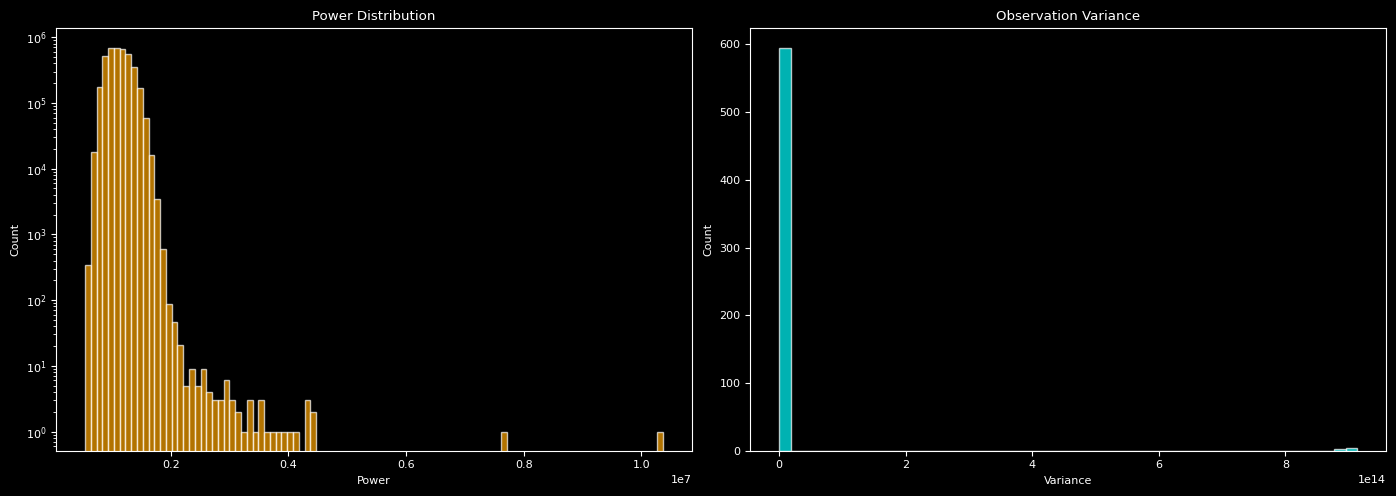

In [108]:
if plates is not None:
    sample = plates[:min(100, len(plates))]

    print(f'Mean power: {np.mean(sample):.2e}')
    print(f'Std power:  {np.std(sample):.2e}')
    print(f'Min:        {np.min(sample):.2e}')
    print(f'Max:        {np.max(sample):.2e}')

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].hist(sample[:10].flatten(), bins=100, color='orange', alpha=0.7, edgecolor='white')
    axes[0].set_xlabel('Power')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Power Distribution')
    axes[0].set_yscale('log')

    var_per_obs = [np.var(obs) for bg in sample for obs in bg]
    axes[1].hist(var_per_obs, bins=50, color='cyan', alpha=0.7, edgecolor='white')
    axes[1].set_xlabel('Variance')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Observation Variance')

    plt.tight_layout()
    plt.show()